In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube

#from astroquery.esasky import ESASky
#from astroquery.utils import TableList
from astropy.wcs import WCS
#from reproject import reproject_interp

In [ ]:
# Replace 'file1.fits' and 'file2.fits' with your actual file names
datafile = 'file1.fits'
maskfile = 'file2.fits'
datamaskedfile=''

data = fits.getdata(datafile)
header = fits.getheader(datafile)
mask = fits.getdata(maskfile)

result_data = data*~mask
hdu = fits.PrimaryHDU(result_data, header=header)
hdu.writeto(datamaskedfile, overwrite=True)

In [ ]:
hi_datafile = '/scratch3/projects/meerchoirs/jcviljoen/output_pbcorr/cubes/cube_2/pbcorr_J1059_09_HI.image.fits'
hi_maskfile = '/scratch3/projects/meerchoirs/jcviljoen/output_pbcorr/cubes/cube_2/mask/pbcorr_J1059_09_HI.image_mask.fits'

In [ ]:
data = fits.getdata(hi_datafile)
header = fits.getheader(hi_datafile)
mask = fits.getdata(hi_maskfile)

In [ ]:
result_data = data*mask

In [ ]:
hdu = fits.PrimaryHDU(result_data, header=header)
hdu.writeto('/scratch3/projects/meerchoirs/jcviljoen/output_pbcorr/cubes/cube_2/mask/pbcorr_J1059_09_HI.image_masked.fits', overwrite=True)

In [2]:
hi_datafile ='/scratch3/projects/meerchoirs/jcviljoen/output_pbcorr/cubes/cube_2/pbcorr_J1059_09_HI.image.fits'

In [3]:
hi_data = fits.open(hi_datafile)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()

In [4]:
print(cube)

SpectralCube with shape=(189, 2048, 2048) and unit=Jy / beam:
 n_x:   2048  type_x: RA---SIN  unit_x: deg    range:   164.239942 deg:  165.396040 deg
 n_y:   2048  type_y: DEC--SIN  unit_y: deg    range:   -10.362355 deg:   -9.225115 deg
 n_s:    189  type_s: VRAD      unit_s: m / s  range:  7508465.359 m / s: 8544933.433 m / s


INFO: Auto-setting vmin to -1.301e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.249e-03 [aplpy.core]


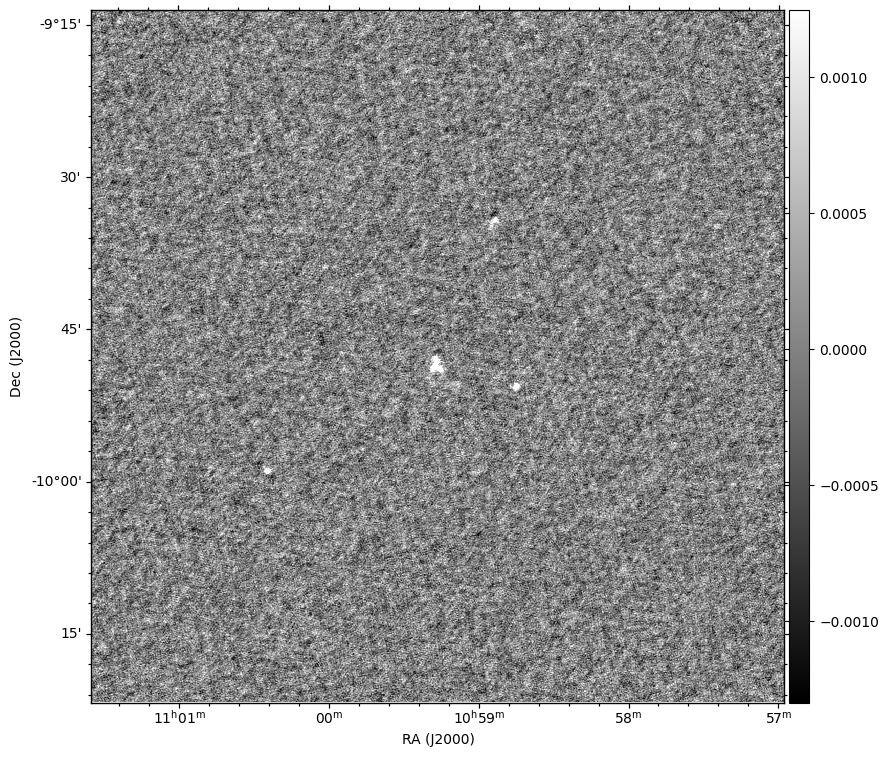

In [5]:
cube[100, :, :].quicklook()

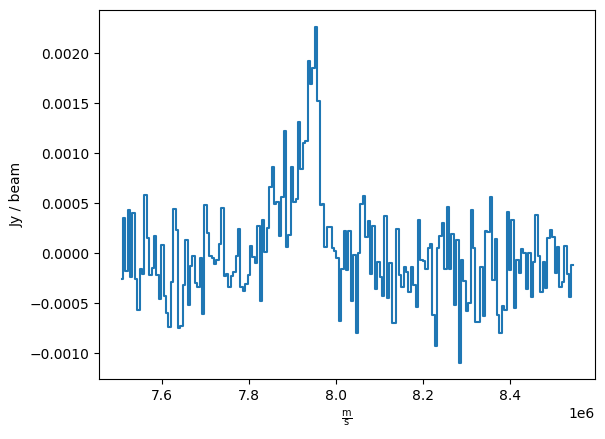

In [6]:
cube[:, 1000, 1000].quicklook() 

In [7]:
_, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :]

In [8]:
lat_range = [-950, -1100] #* u.deg 
lon_range = [950, 1100] #* u.deg

# Create a sub_cube cut to these coordinates
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])

print(sub_cube)

SpectralCube with shape=(189, 150, 150) and unit=Jy / beam:
 n_x:    150  type_x: RA---SIN  unit_x: deg    range:   164.775266 deg:  164.859585 deg
 n_y:    150  type_y: DEC--SIN  unit_y: deg    range:   -10.974025 deg:  -10.891231 deg
 n_s:    189  type_s: VRAD      unit_s: m / s  range:  7508465.359 m / s: 8544933.433 m / s


In [9]:
sub_cube_slab = sub_cube.spectral_slab(7870. *u.km / u.s, 8430. *u.km / u.s)

print(sub_cube_slab)

SpectralCube with shape=(102, 150, 150) and unit=Jy / beam:
 n_x:    150  type_x: RA---SIN  unit_x: deg    range:   164.775266 deg:  164.859585 deg
 n_y:    150  type_y: DEC--SIN  unit_y: deg    range:   -10.974025 deg:  -10.891231 deg
 n_s:    102  type_s: VRAD      unit_s: m / s  range:  7872331.811 m / s: 8429157.744 m / s


In [10]:
moment_0 = cube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment 
moment_1 = cube.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits') 
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  Jy km / (beam s)
Moment_1 has units of:  km / s


In [11]:
print(moment_0.wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 164.817708333333  -9.79394444444445  
CRPIX : 1025.0  1025.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000555555555555556  0.000555555555555556  
NAXIS : 0  0


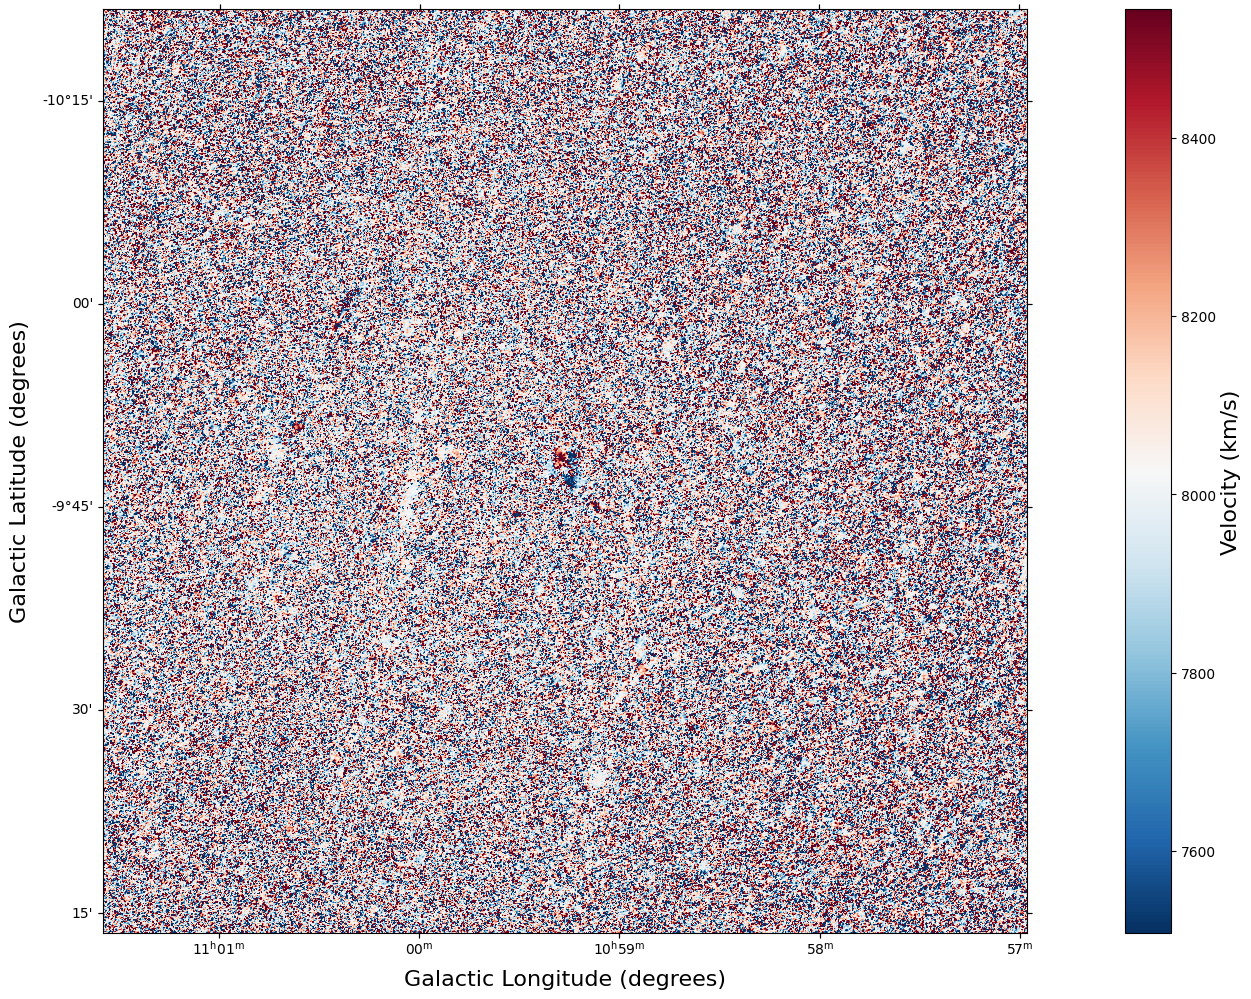

In [12]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=7508, vmax=8544)
ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

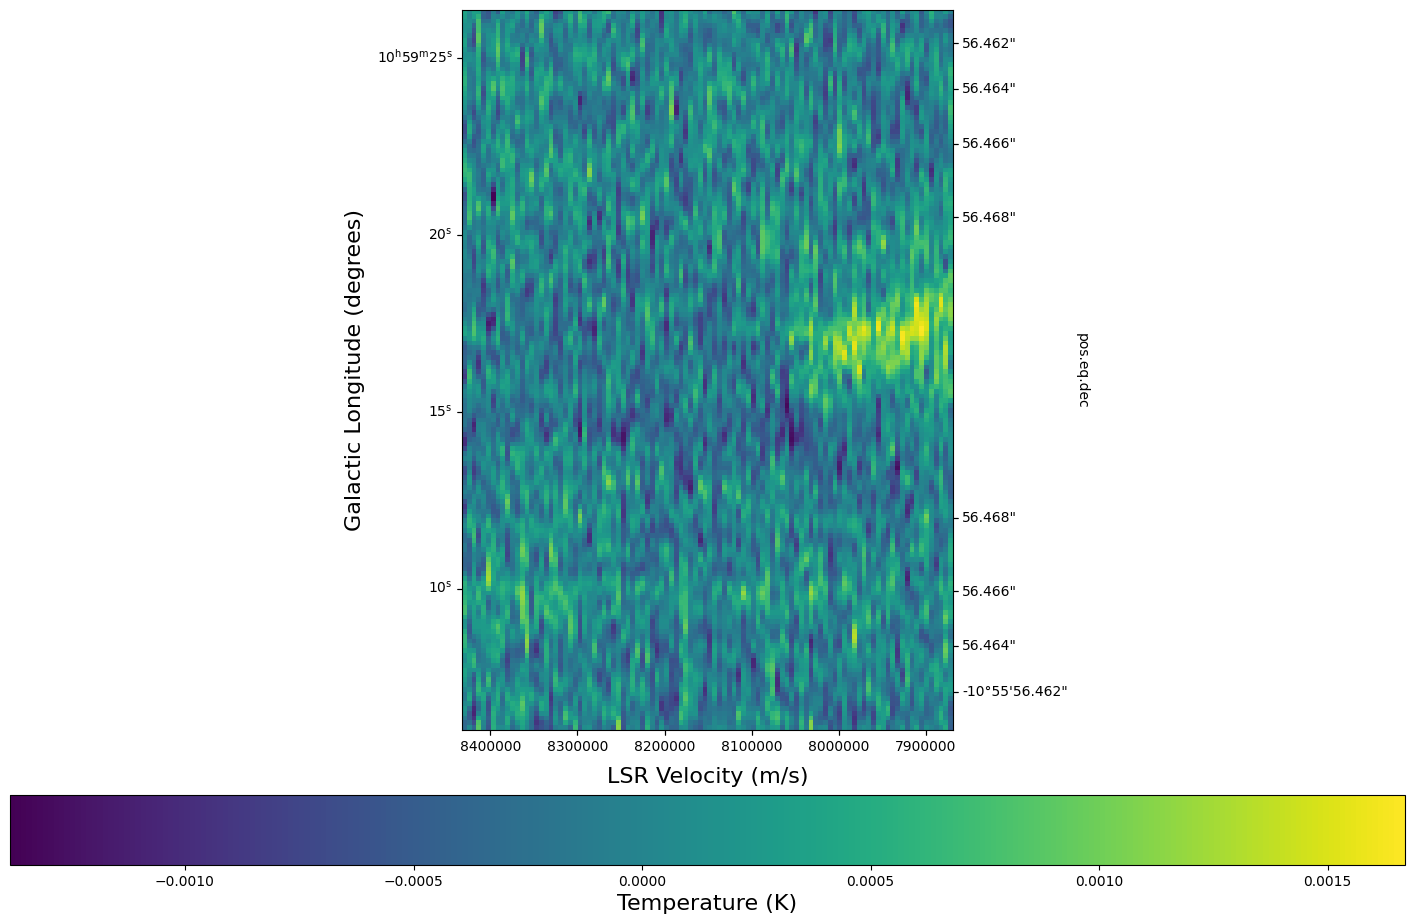

In [13]:
lat_slice = 75 # Index of latitude dimension to slice along

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=sub_cube_slab.wcs, slices=('y', lat_slice, 'x'))
# Above, we have specified to plot the longitude along the y axis, pick only the lat_slice 
# indicated, and plot the velocity along the x axis

# Display the slice
im = ax.imshow(sub_cube_slab[:, lat_slice, :].transpose().data)  # Display the image slice
ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("LSR Velocity (m/s)", fontsize=16)
ax.set_ylabel("Galactic Longitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Temperature (K)', size=16)

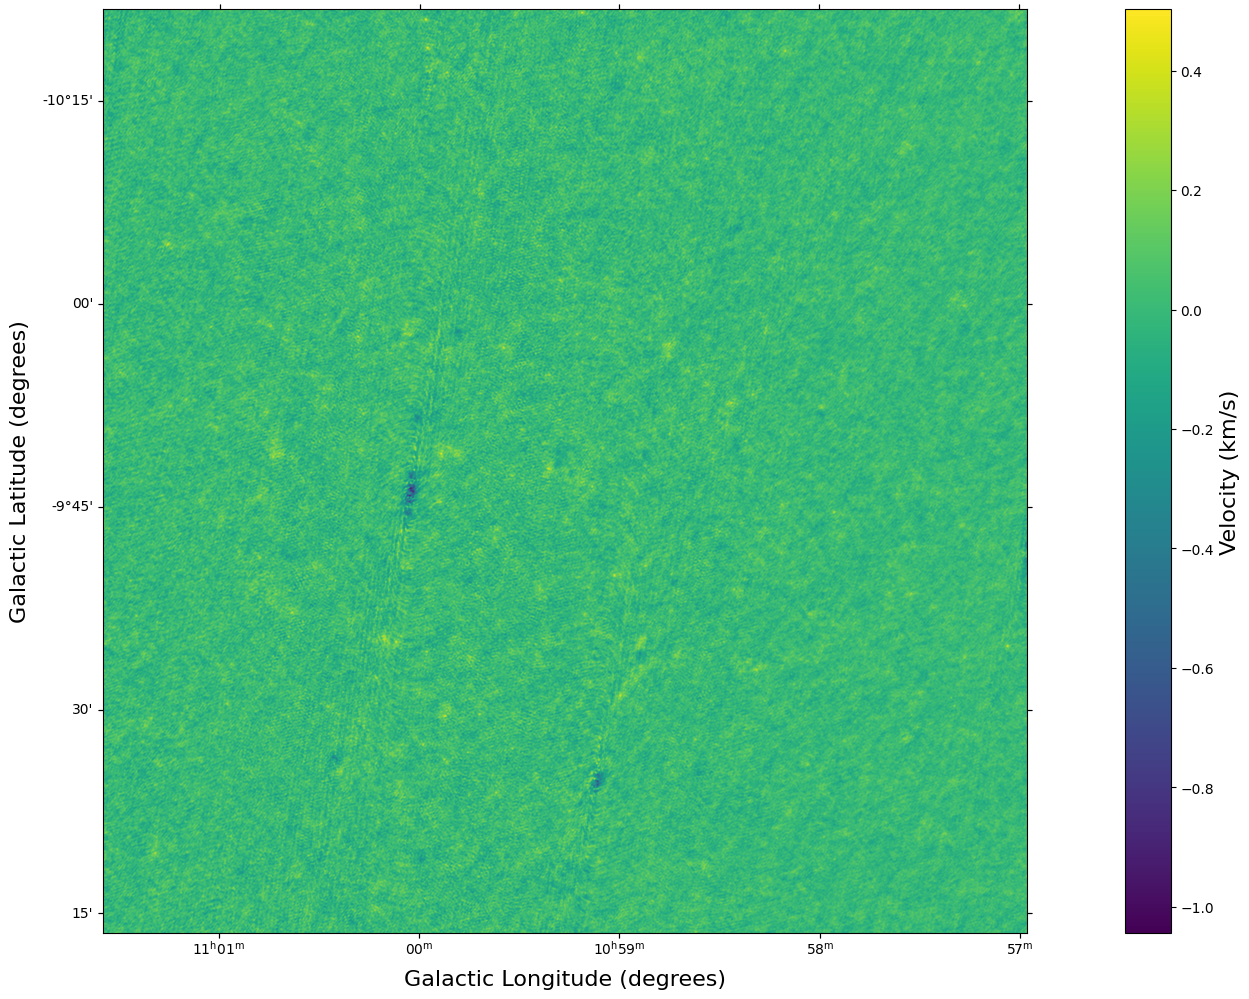

In [14]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_0.wcs)

# Display the moment map image
im = ax.imshow(moment_0.hdu.data)
ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)